In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# !pip install optuna

In [2]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score , roc_auc_score
from xgboost import XGBClassifier
from xgboost import plot_importance
import optuna
import statsmodels.api as sm

In [28]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load pre-trained embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

def compute_alignment_features(resume_text, jd_text, transcript_text):
    features = {}

    # Embedding-based similarity
    resume_embedding = model.encode([resume_text])[0]
    jd_embedding = model.encode([jd_text])[0]
    transcript_embedding = model.encode([transcript_text])[0]

    features['resume_jd_similarity'] = cosine_similarity([resume_embedding], [jd_embedding])[0][0]
    features['transcript_jd_similarity'] = cosine_similarity([transcript_embedding], [jd_embedding])[0][0]

    return features


In [29]:
data = pd.read_excel('/content/drive/MyDrive/final_data.xlsx')

In [30]:
# Sentiment analysis using TestBlob library

In [31]:
from textblob import TextBlob

def analyze_sentiment(text):
    # Create a TextBlob object
    blob = TextBlob(text)

    # Get the sentiment polarity
    polarity = blob.sentiment.polarity

    return polarity

In [32]:
data['Transcript_sentiment'] = data['Transcript_processed'].apply(analyze_sentiment)
data['Resume_sentiment'] = data['Resume_processed'].apply(analyze_sentiment)
data['JobDescription_sentiment'] = data['Job_Description_processed'].apply(analyze_sentiment)

In [33]:
# Word count feature

In [34]:
def word_counts(text):
    return len(text.split())

In [35]:
data['Transcript_words'] = data['Transcript_processed'].apply(word_counts)
data['Resume_words'] = data['Resume_processed'].apply(word_counts)

In [36]:
# Extracting years of experience

In [37]:
import re
from datetime import datetime

def extract_years_of_experience(text):
    # Regular expression to extract years and date ranges
    date_ranges = re.findall(r"(\d{4})-(present|\d{4})", text.lower())

    total_years = 0
    current_year = datetime.now().year

    for start, end in date_ranges:
        start_year = int(start)
        end_year = current_year if end == "present" else int(end)

        total_years += (end_year - start_year)

    return total_years
data['Years_Experience']=data['Resume'].apply(extract_years_of_experience)

In [38]:
# Function for calculating Tf-Idf vectorizer embeddings and then similarity

In [39]:
def compute_tfidf_cosine_similarity(data, col1, col2):
    """
    Computes cosine similarity between resumes and job descriptions using TF-IDF.

    Parameters:
    - data (pd.DataFrame): Dataset containing resumes and job descriptions.
    - resume_col (str): Column name for resumes.
    - jd_col (str): Column name for job descriptions.

    Returns:
    - similarities (list): List of cosine similarity scores for each resume-JD pair.
    """
    similarities = []
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    for _, row in data.iterrows():
        resume_text = row[col1]
        jd_text = row[col2]

        # Combine texts for consistent vectorization
        texts = [resume_text, jd_text]
        tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

        # Convert sparse matrix to dense
        tfidf_dense = tfidf_matrix.toarray()

        # Padding vectors (if needed for consistency)
        max_length = max(len(vector) for vector in tfidf_dense)
        padded_vectors = np.array([np.pad(vector, (0, max_length - len(vector))) for vector in tfidf_dense])

        # Compute cosine similarity
        similarity = cosine_similarity(padded_vectors[0].reshape(1, -1), padded_vectors[1].reshape(1, -1))
        similarities.append(similarity[0][0])

    return similarities

In [40]:
data['resume_jd_similarity'] = compute_tfidf_cosine_similarity(data , 'Resume_processed' , 'Job_Description_processed')

In [41]:
data['Transcript_jd_similarity'] = compute_tfidf_cosine_similarity(data , 'Transcript_processed' , 'Job_Description_processed')

In [42]:
data['resume_transcript_similarity'] = compute_tfidf_cosine_similarity(data , 'Resume_processed' , 'Transcript_processed')

In [43]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [44]:
import re
from nltk.tokenize import word_tokenize, sent_tokenize

In [45]:
## Finding Resume and Job description based features like , skill match count and no.of education degrees from b.tech on wards , etc..

In [46]:
def extract_resume_features(resume_text, jd_text):
    features = {}

    # Length-based features
    features['resume_sentence_count'] = len(sent_tokenize(resume_text))
    features['resume_avg_word_length'] = sum(len(word) for word in word_tokenize(resume_text)) / len(word_tokenize(resume_text))

    # Skill match features
    jd_skills = set(re.findall(r'\b[A-Za-z]+\b', jd_text.lower()))
    resume_skills = set(re.findall(r'\b[A-Za-z]+\b', resume_text.lower()))
    features['skill_match_count'] = len(jd_skills & resume_skills)

    # Education features
    degrees = ['b.tech', 'm.tech', 'mba', 'phd', 'bachelor', 'master']
    features['university_education_count'] = sum(1 for degree in degrees if degree in resume_text.lower())

    return features


In [47]:
def process_dataset(data, resume_col, jd_col):
    """
    Process a dataset to extract features for each resume-JD pair.

    Parameters:
    - data (pd.DataFrame): Dataset containing resumes and job descriptions.
    - resume_col (str): Column name for resumes.
    - jd_col (str): Column name for job descriptions.

    Returns:
    - pd.DataFrame: Original dataset with extracted features appended.
    """
    extracted_features = []

    for _, row in data.iterrows():
        resume_text = row[resume_col]
        jd_text = row[jd_col]
        features = extract_resume_features(resume_text, jd_text)
        extracted_features.append(features)

    # Combine features into a DataFrame
    features_df = pd.DataFrame(extracted_features)
    return pd.concat([data, features_df], axis=1)

# Process the dataset
processed_data = process_dataset(data, "Resume_processed", "Job_Description_processed")


In [48]:
processed_data.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Role', 'Transcript', 'Resume', 'decision',
       'Reason for decision', 'Job Description', 'Transcript_processed',
       'Resume_processed', 'Job_Description_processed', 'Transcript_sentiment',
       'Resume_sentiment', 'JobDescription_sentiment', 'Transcript_words',
       'Resume_words', 'Years_Experience', 'resume_jd_similarity',
       'Transcript_jd_similarity', 'resume_transcript_similarity',
       'resume_sentence_count', 'resume_avg_word_length', 'skill_match_count',
       'university_education_count'],
      dtype='object')

In [49]:
## Extracting the features from transcript like vocabulary diversity , avg_sentence_length

In [50]:
def extract_transcript_features(transcript_text):
    features = {}
    # Language features
    features['transcript_vocab_diversity'] = len(set(word_tokenize(transcript_text))) / len(word_tokenize(transcript_text))
    features['transcript_avg_sentence_length'] = sum(len(sent.split()) for sent in sent_tokenize(transcript_text)) / len(sent_tokenize(transcript_text))
    return features


In [51]:
def process_transcript(data, transcript_col = 'Transcript_processed'):
    extracted_features = []

    for _, row in data.iterrows():
        transcript_text = row[transcript_col]
        features = extract_transcript_features(transcript_text)
        extracted_features.append(features)

    # Combine features into a DataFrame
    features_df = pd.DataFrame(extracted_features)
    return pd.concat([data, features_df], axis=1)

# Process the dataset
processed_data = process_transcript(processed_data)


In [52]:
processed_data.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Role', 'Transcript', 'Resume', 'decision',
       'Reason for decision', 'Job Description', 'Transcript_processed',
       'Resume_processed', 'Job_Description_processed', 'Transcript_sentiment',
       'Resume_sentiment', 'JobDescription_sentiment', 'Transcript_words',
       'Resume_words', 'Years_Experience', 'resume_jd_similarity',
       'Transcript_jd_similarity', 'resume_transcript_similarity',
       'resume_sentence_count', 'resume_avg_word_length', 'skill_match_count',
       'university_education_count', 'transcript_vocab_diversity',
       'transcript_avg_sentence_length'],
      dtype='object')

In [53]:
processed_data.to_excel('final_data_features.xlsx')

# ***Building Complete models using Tf-Idf embeddings similarity:***

In [54]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


In [55]:
req_data = processed_data[['Transcript_sentiment',
       'Resume_sentiment', 'JobDescription_sentiment', 'Transcript_words',
       'Resume_words', 'Years_Experience', 'resume_jd_similarity',
       'Transcript_jd_similarity', 'resume_transcript_similarity',
       'resume_sentence_count', 'resume_avg_word_length', 'skill_match_count',
       'university_education_count', 'transcript_vocab_diversity',
       'transcript_avg_sentence_length' , 'decision']]

In [56]:
req_data['decision_processed'] = req_data['decision'].apply(lambda x : 1 if x == 'select' else 0)

In [57]:
req_data.head()

,Transcript_sentiment,Resume_sentiment,JobDescription_sentiment,Transcript_words,Resume_words,Years_Experience,resume_jd_similarity,Transcript_jd_similarity,resume_transcript_similarity,resume_sentence_count,resume_avg_word_length,skill_match_count,university_education_count,transcript_vocab_diversity,transcript_avg_sentence_length,decision,decision_processed
0,0.270412,0.307407,0.50,348,221,14,0.268642,0.203080,0.226753,1,7.737557,8,2,0.548851,348.0,select,1
1,0.296350,0.130833,0.50,387,241,11,0.238920,0.098115,0.169317,1,7.676349,7,2,0.591731,387.0,select,1
2,0.173791,0.202970,0.50,282,255,14,0.375988,0.155779,0.346429,1,7.117647,9,1,0.475177,282.0,reject,0
3,0.198376,0.131515,0.50,402,237,7,0.248950,0.175580,0.235884,1,7.130802,7,1,0.519900,402.0,select,1
4,0.324771,0.111750,0.25,306,299,0,0.307717,0.113163,0.180783,1,7.394649,9,2,0.522876,306.0,reject,0


1. Splitting the data for training and testing  

In [58]:
x , y = req_data.drop(columns = ['decision' , 'decision_processed']) , req_data['decision_processed']

In [59]:
train_x , test_x , train_y , test_y = train_test_split(x,y,train_size = 0.8 , random_state = 42)

In [60]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2366 entries, 2915 to 860
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Transcript_sentiment            2366 non-null   float64
 1   Resume_sentiment                2366 non-null   float64
 2   JobDescription_sentiment        2366 non-null   float64
 3   Transcript_words                2366 non-null   int64  
 4   Resume_words                    2366 non-null   int64  
 5   Years_Experience                2366 non-null   int64  
 6   resume_jd_similarity            2366 non-null   float64
 7   Transcript_jd_similarity        2366 non-null   float64
 8   resume_transcript_similarity    2366 non-null   float64
 9   resume_sentence_count           2366 non-null   int64  
 10  resume_avg_word_length          2366 non-null   float64
 11  skill_match_count               2366 non-null   int64  
 12  university_education_count      2366 

In [61]:
train_y.head()

,decision_processed
2915,1
573,0
1553,0
1877,0
2954,0


In [62]:
# pip install optuna

In [63]:
## Optuna is used for hyper parameter tuning

In [64]:
## Addding the minor noise in order to eliminate perfect correlation for logistic regression implementation in statsmodels library
train_x += np.random.normal(0, 1e-4, train_x.shape)
test_x += np.random.normal(0, 1e-4, test_x.shape)

Logistic regression model building and analysis

In [65]:

# Logistic Regression using statsmodels
def logistic_regression_statsmodels(train_x, train_y):
    X_train_const = sm.add_constant(train_x)  # Add intercept
    model = sm.Logit(train_y, X_train_const)
    result = model.fit()
    print(result.summary())
    return result

# Logistic Regression Model
logistic_model = logistic_regression_statsmodels(train_x, train_y)
X_test_const = sm.add_constant(test_x)
y_pred_logistic = (logistic_model.predict(X_test_const) > 0.5).astype(int)

# Logistic Regression Evaluation
print("Logistic Regression Metrics:")
print("Accuracy:", accuracy_score(test_y, y_pred_logistic))
print("Precision:", precision_score(test_y, y_pred_logistic))
print("Recall:", recall_score(test_y, y_pred_logistic))
print("F1 Score:", f1_score(test_y, y_pred_logistic))
print("roc_auc Score:", roc_auc_score(test_y, y_pred_logistic))


         Current function value: 0.471029
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:     decision_processed   No. Observations:                 2366
Model:                          Logit   Df Residuals:                     2350
Method:                           MLE   Df Model:                           15
Date:                Sun, 12 Jan 2025   Pseudo R-squ.:                  0.3201
Time:                        02:17:59   Log-Likelihood:                -1114.5
converged:                      False   LL-Null:                       -1639.2
Covariance Type:            nonrobust   LLR p-value:                3.392e-214
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            126.3097    525.456      0.240      0.810    -903.566    1156.185
Trans

1. from this model it came to know that Transcript words , resume_job desc similarity are not much useful
2. resume transcript similarity , transcript avg sentence length , resume sent count , university count , resume avg words are also not uyseful

This might be due to Tf-idf transformer


In [66]:
# model without those cols ,
x1 , y1 = req_data.drop(columns = ['decision' , 'decision_processed' , 'Transcript_words' , 'resume_jd_similarity' , 'resume_transcript_similarity' , 'resume_sentence_count' , 'university_education_count' , 'resume_avg_word_length' , 'transcript_avg_sentence_length' , 'Resume_words' , 'Years_Experience']) , req_data['decision_processed']

In [67]:
train_x1 , test_x1 , train_y1 , test_y1 = train_test_split(x1,y1,train_size = 0.8 , random_state = 42)

In [68]:

# Logistic Regression using statsmodels
def logistic_regression_statsmodels(train_x, train_y):
    X_train_const = sm.add_constant(train_x)  # Add intercept
    model = sm.Logit(train_y, X_train_const)
    result = model.fit()
    print(result.summary())
    return result

# Logistic Regression Model
logistic_model = logistic_regression_statsmodels(train_x1, train_y1)
X_test_const = sm.add_constant(test_x1)
y_pred_logistic = (logistic_model.predict(X_test_const) > 0.5).astype(int)

# Logistic Regression Evaluation
print("Logistic Regression Metrics:")
print("Accuracy:", accuracy_score(test_y1, y_pred_logistic))
print("Precision:", precision_score(test_y1, y_pred_logistic))
print("Recall:", recall_score(test_y1, y_pred_logistic))
print("F1 Score:", f1_score(test_y1, y_pred_logistic))
print("roc_auc Score:", roc_auc_score(test_y1, y_pred_logistic))


Optimization terminated successfully.
         Current function value: 0.591976
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:     decision_processed   No. Observations:                 2366
Model:                          Logit   Df Residuals:                     2359
Method:                           MLE   Df Model:                            6
Date:                Sun, 12 Jan 2025   Pseudo R-squ.:                  0.1455
Time:                        02:17:59   Log-Likelihood:                -1400.6
converged:                       True   LL-Null:                       -1639.2
Covariance Type:            nonrobust   LLR p-value:                7.126e-100
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -4.3295      0.532     -8.139      0.000      

In [69]:

# XGBoost with Optuna for Hyperparameter Tuning
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
    }

    model = XGBClassifier(**params, use_label_encoder=False, eval_metric="logloss", random_state=42)
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    return accuracy_score(test_y, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Best hyperparameters
print("Best parameters:", study.best_params)

# Train XGBoost with best parameters
best_params = study.best_params
xgb_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(train_x, train_y)
y_pred_xgb = xgb_model.predict(test_x)

# XGBoost Evaluation
print("XGBoost Metrics:")
print("Accuracy:", accuracy_score(test_y, y_pred_xgb))
print("Precision:", precision_score(test_y, y_pred_xgb))
print("Recall:", recall_score(test_y, y_pred_xgb))
print("F1 Score:", f1_score(test_y, y_pred_xgb))

[I 2025-01-12 02:18:00,077] A new study created in memory with name: no-name-acf0fe0c-3114-44a4-abb6-dddb5426b603
[I 2025-01-12 02:18:00,397] Trial 0 finished with value: 0.7837837837837838 and parameters: {'n_estimators': 195, 'max_depth': 6, 'learning_rate': 0.17354455463060883, 'subsample': 0.6799522894335595, 'colsample_bytree': 0.6343637370119557, 'gamma': 2.237329251728169, 'min_child_weight': 10}. Best is trial 0 with value: 0.7837837837837838.
[I 2025-01-12 02:18:00,776] Trial 1 finished with value: 0.7888513513513513 and parameters: {'n_estimators': 431, 'max_depth': 5, 'learning_rate': 0.21359117609685604, 'subsample': 0.9030144682318534, 'colsample_bytree': 0.5970743825080747, 'gamma': 0.5448561432978938, 'min_child_weight': 4}. Best is trial 1 with value: 0.7888513513513513.
[I 2025-01-12 02:18:01,103] Trial 2 finished with value: 0.7837837837837838 and parameters: {'n_estimators': 321, 'max_depth': 4, 'learning_rate': 0.07350612456527841, 'subsample': 0.6898050836834445, '

Best parameters: {'n_estimators': 737, 'max_depth': 6, 'learning_rate': 0.2546858635970743, 'subsample': 0.8948253200739285, 'colsample_bytree': 0.8968385132483248, 'gamma': 4.089453326963702, 'min_child_weight': 5}
XGBoost Metrics:
Accuracy: 0.8074324324324325
Precision: 0.78839590443686
Recall: 0.8162544169611308
F1 Score: 0.8020833333333334


<Figure size 1000x800 with 0 Axes>

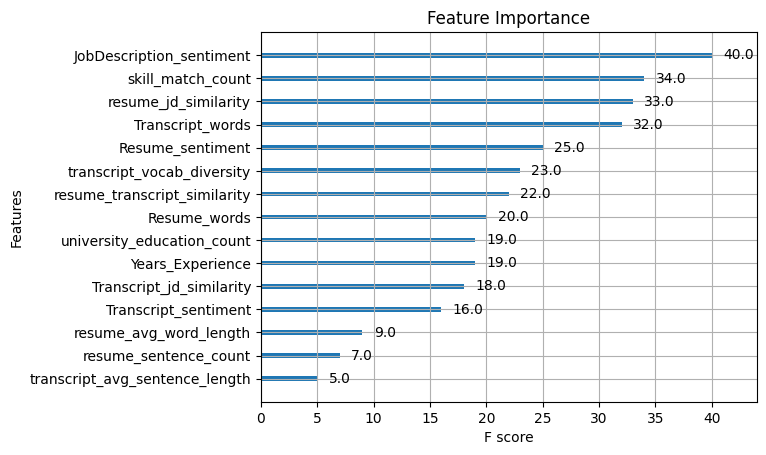

In [70]:
## Plotting the feature importance for Xgboost model
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, importance_type='weight', title='Feature Importance')
plt.show()

In [71]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train and evaluate Naive Bayes
nb_model = GaussianNB()
nb_model.fit(train_x, train_y)  # Fit the model
y_pred_nb = nb_model.predict(test_x)  # Predict on test set

# Evaluation
print("Naive Bayes Metrics (TF-IDF):")
print("Accuracy:", accuracy_score(test_y, y_pred_nb))
print("Precision:", precision_score(test_y, y_pred_nb))
print("Recall:", recall_score(test_y, y_pred_nb))
print("F1 Score:", f1_score(test_y, y_pred_nb))


Naive Bayes Metrics (TF-IDF):
Accuracy: 0.7297297297297297
Precision: 0.7573221757322176
Recall: 0.6395759717314488
F1 Score: 0.6934865900383141


In [72]:
from sklearn.ensemble import RandomForestClassifier

# Train and evaluate Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(train_x, train_y)  # Fit the model
y_pred_rf = rf_model.predict(test_x)  # Predict on test set

# Evaluation
print("Random Forest Metrics (TF-IDF):")
print("Accuracy:", accuracy_score(test_y, y_pred_rf))
print("Precision:", precision_score(test_y, y_pred_rf))
print("Recall:", recall_score(test_y, y_pred_rf))
print("F1 Score:", f1_score(test_y, y_pred_rf))

Random Forest Metrics (TF-IDF):
Accuracy: 0.8006756756756757
Precision: 0.7894736842105263
Recall: 0.7950530035335689
F1 Score: 0.7922535211267606


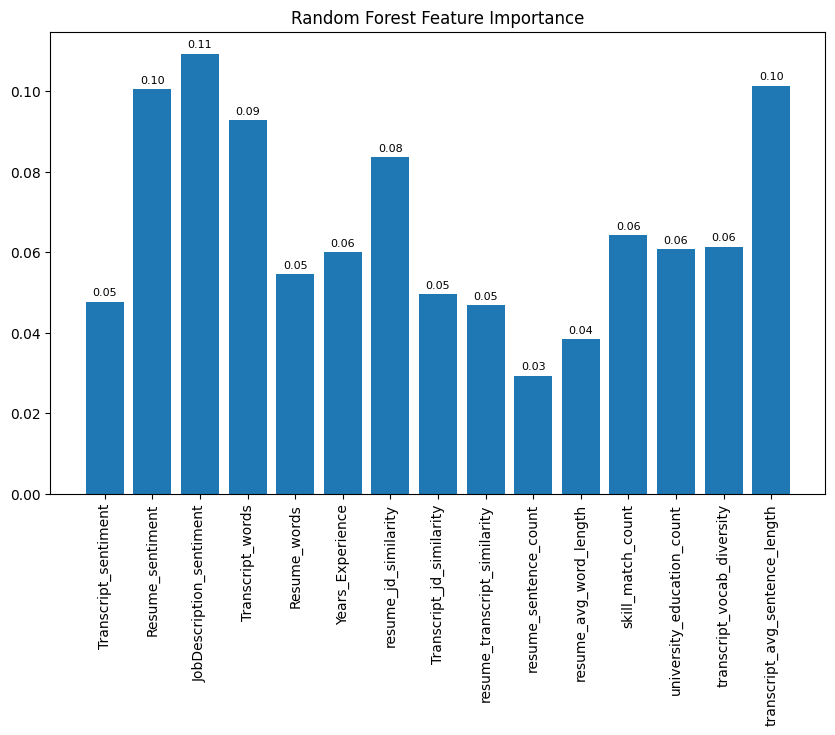

In [76]:
# Add values on top of the bars
importance = rf_model.feature_importances_


plt.figure(figsize=(10, 6))
plt.bar(train_x.columns, importance)
plt.xticks(rotation=90)
plt.title("Random Forest Feature Importance")

# Annotate each bar with its value
for i, v in enumerate(importance):
    plt.text(i, v + 0.001, f"{v:.2f}", ha='center', va='bottom', fontsize=8)

plt.show()

In [77]:
from sklearn.svm import SVC

# Train and evaluate SVC
svc_model = SVC(kernel="linear", random_state=42)
svc_model.fit(train_x, train_y)  # Fit the model
y_pred_svc = svc_model.predict(test_x)  # Predict on test set

# Evaluation
print("SVC Metrics (TF-IDF):")
print("Accuracy:", accuracy_score(test_y, y_pred_svc))
print("Precision:", precision_score(test_y, y_pred_svc))
print("Recall:", recall_score(test_y, y_pred_svc))
print("F1 Score:", f1_score(test_y, y_pred_svc))


SVC Metrics (TF-IDF):
Accuracy: 0.7820945945945946
Precision: 0.7851851851851852
Recall: 0.7491166077738516
F1 Score: 0.7667269439421338


# ***Computation of Similarity scores between resume , transcript , job description using Sentence Transformers Library***

In [78]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [80]:
def compute_alignment_features(resume_text, jd_text, transcript_text):
    features = {}

    """Embedding-based similarity"""
    resume_embedding = model.encode([resume_text])[0]
    jd_embedding = model.encode([jd_text])[0]
    transcript_embedding = model.encode([transcript_text])[0]

    features['resume_jd_similarity_transformers'] = cosine_similarity([resume_embedding], [jd_embedding])[0][0]
    features['transcript_jd_similarity_transformers'] = cosine_similarity([transcript_embedding], [jd_embedding])[0][0]
    features['transcript_resume_similarity_transformers'] = cosine_similarity([transcript_embedding], [resume_embedding])[0][0]

    return features

def process_transformer_similarity(data):
    extracted_features = []

    for _, row in data.iterrows():
        resume_text = row['Resume_processed']
        jd_text = row['Job_Description_processed']
        transcript_text = row['Transcript_processed']
        features = compute_alignment_features(resume_text, jd_text, transcript_text)
        extracted_features.append(features)

    # Combine features into a DataFrame
    features_df = pd.DataFrame(extracted_features)
    return pd.concat([data, features_df], axis=1)

# Process the dataset
processed_data = process_transformer_similarity(processed_data)


In [81]:
processed_data.columns

In [3]:
processed_data = pd.read_excel('/content/processed_data.xlsx')

In [22]:
req_data = processed_data[['Transcript_sentiment',
       'Resume_sentiment', 'JobDescription_sentiment', 'Transcript_words',
       'Resume_words', 'Years_Experience', 'resume_jd_similarity_transformers',
       'transcript_jd_similarity_transformers',
       'transcript_resume_similarity_transformers',
       'resume_sentence_count', 'resume_avg_word_length', 'skill_match_count',
       'university_education_count', 'transcript_vocab_diversity',
       'transcript_avg_sentence_length' , 'decision']]
req_data['decision_processed'] = req_data['decision'].apply(lambda x : 1 if x == 'select' else 0)
x , y = req_data.drop(columns = ['decision' , 'decision_processed']) , req_data['decision_processed']
train_x , test_x , train_y , test_y = train_test_split(x,y,train_size = 0.8 , random_state = 42)

<ipython-input-22-553210a29dab>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  req_data['decision_processed'] = req_data['decision'].apply(lambda x : 1 if x == 'select' else 0)


In [23]:
train_x += np.random.normal(0, 1e-4, train_x.shape)
test_x += np.random.normal(0, 1e-4, test_x.shape)

# ***Building Complete models using sentence Transformer embeddings similarity:***

In [86]:
# Logistic Regression using statsmodels
def logistic_regression_statsmodels(train_x, train_y):
    X_train_const = sm.add_constant(train_x)  # Add intercept
    model = sm.Logit(train_y, X_train_const)
    result = model.fit()
    print(result.summary())
    return result

# Logistic Regression Model
logistic_model = logistic_regression_statsmodels(train_x, train_y)
X_test_const = sm.add_constant(test_x)
y_pred_logistic = (logistic_model.predict(X_test_const) > 0.5).astype(int)

# Logistic Regression Evaluation
print("Logistic Regression Metrics:")
print("Accuracy:", accuracy_score(test_y, y_pred_logistic))
print("Precision:", precision_score(test_y, y_pred_logistic))
print("Recall:", recall_score(test_y, y_pred_logistic))
print("F1 Score:", f1_score(test_y, y_pred_logistic))
print("roc_auc Score:", roc_auc_score(test_y, y_pred_logistic))


         Current function value: 0.461481
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:     decision_processed   No. Observations:                 2366
Model:                          Logit   Df Residuals:                     2350
Method:                           MLE   Df Model:                           15
Date:                Sun, 12 Jan 2025   Pseudo R-squ.:                  0.3339
Time:                        02:29:02   Log-Likelihood:                -1091.9
converged:                      False   LL-Null:                       -1639.2
Covariance Type:            nonrobust   LLR p-value:                6.885e-224
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                     -1359.0012    537.382     -2.529      0.

After using the Sentence transformers for finding similarity we got that
resume jd similarity and resume transcript similarity as useful features

In [28]:

# XGBoost with Optuna for Hyperparameter Tuning
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
    }

    model = XGBClassifier(**params, use_label_encoder=False, eval_metric="logloss", random_state=42)
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    return accuracy_score(test_y, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Best hyperparameters
print("Best parameters:", study.best_params)

# Train XGBoost with best parameters
best_params = study.best_params
xgb_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(train_x, train_y)
y_pred_xgb = xgb_model.predict(test_x)

# XGBoost Evaluation
print("XGBoost Metrics:")
print("Accuracy:", accuracy_score(test_y, y_pred_xgb))
print("Precision:", precision_score(test_y, y_pred_xgb))
print("Recall:", recall_score(test_y, y_pred_xgb))
print("F1 Score:", f1_score(test_y, y_pred_xgb))

[I 2025-01-12 03:51:34,330] A new study created in memory with name: no-name-137af27b-a33d-49e8-b16c-14a6098219b1
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-01-12 03:51:36,803] Trial 0 finished with value: 0.7905405405405406 and parameters: {'n_estimators': 606, 'max_depth': 8, 'learning_rate': 0.18262112365436092, 'subsample': 0.6608315628300343, 'colsample_bytree': 0.9814682952389069, 'gamma': 1.4175128615302328, 'min_child_weight': 10}. Best is trial 0 with value: 0.7905405405405406.
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-01-12 03:51:40,661] Trial 1 finished with value: 0.8006756756756757 and parameters: {'n_estimators': 821, 'max_depth': 3, 'learning_rate': 0.28526492355888816, 'subs

Best parameters: {'n_estimators': 125, 'max_depth': 8, 'learning_rate': 0.039946429873294775, 'subsample': 0.9300805158132333, 'colsample_bytree': 0.9959334839257619, 'gamma': 0.1101936130679082, 'min_child_weight': 4}
XGBoost Metrics:
Accuracy: 0.831081081081081
Precision: 0.8080808080808081
Recall: 0.8480565371024735
F1 Score: 0.8275862068965517


<Figure size 1000x800 with 0 Axes>

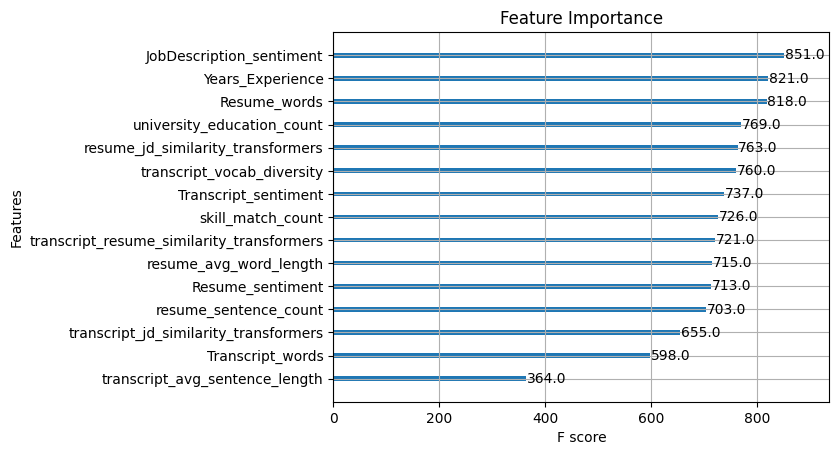

In [88]:
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, importance_type='weight', title='Feature Importance')
plt.show()

In [89]:
# Train and evaluate Naive Bayes
nb_model2 = GaussianNB()
nb_model2.fit(train_x, train_y)  # Fit the model
y_pred_nb = nb_model2.predict(test_x)  # Predict on test set

# Evaluation
print("Naive Bayes Metrics (SentenceTransformer):")
print("Accuracy:", accuracy_score(test_y, y_pred_nb))
print("Precision:", precision_score(test_y, y_pred_nb))
print("Recall:", recall_score(test_y, y_pred_nb))
print("F1 Score:", f1_score(test_y, y_pred_nb))


Naive Bayes Metrics (SentenceTransformer):
Accuracy: 0.7364864864864865
Precision: 0.7613168724279835
Recall: 0.6537102473498233
F1 Score: 0.7034220532319392


In [90]:
importance = 1 / np.sqrt(nb_model2.var_)
mean_importance = importance.mean(axis=0)  # Average across classes
print("Mean Feature Importance:", mean_importance)

Mean Feature Importance: [1.94894112e+01 1.25389384e+01 4.44765326e+00 1.26964474e-02
 2.38851651e-02 1.47528555e-01 5.38965839e+00 6.38905370e+00
 1.29490963e+01 3.73789206e+02 3.59447596e+00 4.38903839e-02
 1.11742425e+00 1.90984334e+01 1.26964475e-02]


In [91]:
# Train and evaluate Random Forest Classifier
rf_model2 = RandomForestClassifier(random_state=42)
rf_model2.fit(train_x, train_y)  # Fit the model
y_pred_rf = rf_model2.predict(test_x)  # Predict on test set

# Evaluation
print("Random Forest Metrics (SentenceTransformer):")
print("Accuracy:", accuracy_score(test_y, y_pred_rf))
print("Precision:", precision_score(test_y, y_pred_rf))
print("Recall:", recall_score(test_y, y_pred_rf))
print("F1 Score:", f1_score(test_y, y_pred_rf))


Random Forest Metrics (SentenceTransformer):
Accuracy: 0.8158783783783784
Precision: 0.8041958041958042
Recall: 0.8127208480565371
F1 Score: 0.8084358523725835


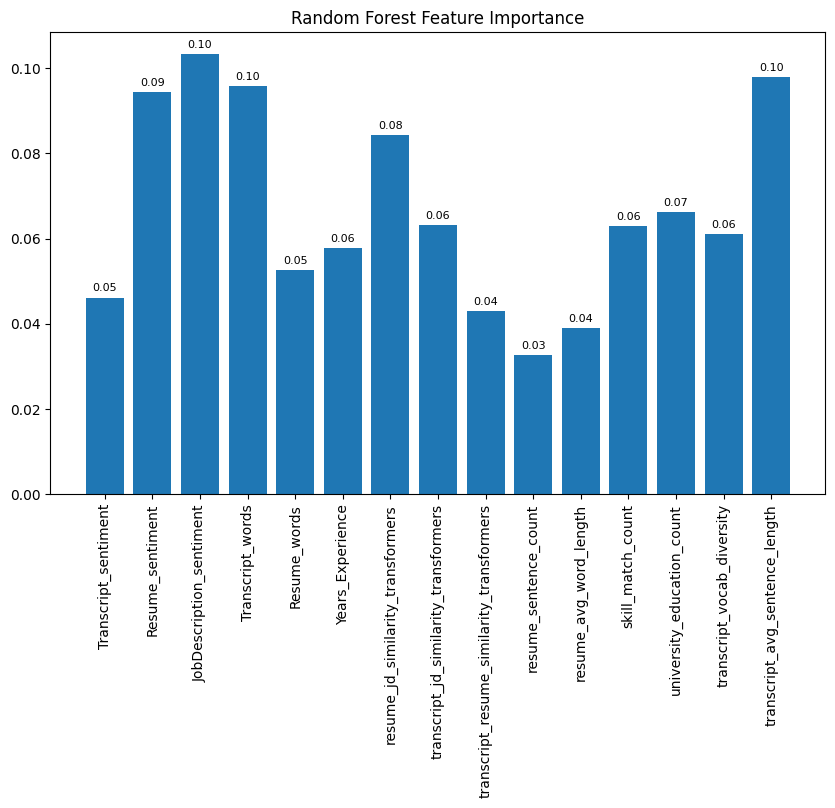

In [92]:
importance = rf_model2.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(x.columns, importance)
plt.xticks(rotation=90)
plt.title("Random Forest Feature Importance")
for i, v in enumerate(importance):
    plt.text(i, v + 0.001, f"{v:.2f}", ha='center', va='bottom', fontsize=8)

plt.show()


In [93]:
# Train and evaluate SVC
svc_model = SVC(kernel="linear", random_state=42)
svc_model.fit(train_x, train_y)  # Fit the model
y_pred_svc = svc_model.predict(test_x)  # Predict on test set

# Evaluation
print("SVC Metrics (SentenceTransformer):")
print("Accuracy:", accuracy_score(test_y, y_pred_svc))
print("Precision:", precision_score(test_y, y_pred_svc))
print("Recall:", recall_score(test_y, y_pred_svc))
print("F1 Score:", f1_score(test_y, y_pred_svc))


SVC Metrics (SentenceTransformer):
Accuracy: 0.8006756756756757
Precision: 0.8113207547169812
Recall: 0.7597173144876325
F1 Score: 0.7846715328467153


# ***In comparision to all the models, ***

# ***XGBOOST model is working well with the data as it is giving high accuracy , with sentence transformers ***

In [ ]:
# so saving the best model

In [94]:
y_pred_xgb = xgb_model.predict(test_x)

# XGBoost Evaluation
print("XGBoost Metrics:")
print("Accuracy:", accuracy_score(test_y, y_pred_xgb))
print("Precision:", precision_score(test_y, y_pred_xgb))
print("Recall:", recall_score(test_y, y_pred_xgb))
print("F1 Score:", f1_score(test_y, y_pred_xgb))

XGBoost Metrics:
Accuracy: 0.8277027027027027
Precision: 0.7986798679867987
Recall: 0.8551236749116607
F1 Score: 0.825938566552901


In [29]:
import joblib

# Save the model
joblib.dump(model, 'xgb_classifier_model.pkl')

['xgb_classifier_model.pkl']

In [30]:
import joblib

# Load the model
model = joblib.load('xgb_classifier_model.pkl')


In [ ]:
## Post Processing after model building

In [99]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Initialize SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_x)



## **Feature Importance using Beswarm Plot**

#### 1. **Transcript_words**
##### Observation: A higher number of words in the transcript (red points) increases the prediction probability, while fewer words (blue points) decrease it.
##### Impact: Highly positive feature, indicating that longer transcripts are associated with better outcomes.

#### 2. **transcript_avg_sentence_length**
##### Observation: Longer average sentence lengths (red points) tend to slightly increase prediction probabilities. Shorter lengths (blue points) reduce them.
##### Impact: Moderate positive influence, suggesting coherence or richness in sentence structure contributes positively.

#### 3. **JobDescription_sentiment**
##### Observation: Positive sentiment in job descriptions (red points) slightly improves the prediction. Negative sentiment (blue points) reduces it.
##### Impact: A small but meaningful role in aligning candidate attributes with the tone of the job description.

#### 4. **Resume_sentiment**
##### Observation: Resumes with positive sentiment (red points) improve prediction probability, while those with negative sentiment (blue points) lower it.
##### Impact: Moderate positive influence, showing that optimistic or enthusiastic resumes may be more impactful.

#### 5. **university_education_count**
##### Observation: Higher counts (e.g., multiple degrees or certifications, red points) improve prediction. Lower counts (blue points) decrease probability.
##### Impact: Strong positive feature, suggesting higher educational credentials positively influence predictions.

#### 6. **transcript_vocab_diversity**
##### Observation: Higher vocabulary diversity (red points) is associated with higher prediction probabilities. Lower diversity (blue points) reduces it.
##### Impact: Indicates that varied and sophisticated vocabulary in transcripts is advantageous.

#### 7. **resume_jd_similarity_transformers**
##### Observation: Higher similarity scores between the resume and job description (red points) improve prediction probabilities. Lower scores (blue points) reduce them.
##### Impact: Critical feature, suggesting alignment between a candidate's resume and job requirements is vital.

#### 8. **Resume_words**
##### Observation: A higher number of words in resumes (red points) slightly increases prediction probability. Fewer words (blue points) decrease it.
##### Impact: Moderate feature, indicating detailed resumes may perform better.

#### 9. **Years_Experience**
##### Observation: More years of experience (red points) increase prediction probabilities, while fewer years (blue points) decrease them.
##### Impact: Strong positive influence, as experience correlates with job suitability.

#### 10. **transcript_jd_similarity_transformers**
##### Observation: Higher similarity between the transcript and job description (red points) improves predictions, while lower similarity (blue points) decreases them.
##### Impact: Significant feature, emphasizing the importance of aligning communication (e.g., during interviews) with job requirements.

#### 11. **Transcript_sentiment**
##### Observation: Positive sentiment in the transcript (red points) increases prediction probabilities. Negative sentiment (blue points) decreases them.
##### Impact: Moderate role, showing that a positive tone during communication is beneficial.

#### 12. **resume_sentence_count**
##### Observation: Resumes with more sentences (red points) increase prediction probabilities. Fewer sentences (blue points) reduce them.
##### Impact: Indicates that detailed resumes with clear segmentation are advantageous.

#### 13. **resume_avg_word_length**
##### Observation: Longer average word lengths (red points) tend to increase prediction probabilities. Shorter words (blue points) decrease them.
##### Impact: Indicates that using more sophisticated vocabulary positively influences predictions.

#### 14. **skill_match_count**
##### Observation: Higher skill matches (red points) significantly increase prediction probabilities. Fewer matches (blue points) decrease them.
##### Impact: Critical feature, as skill alignment is fundamental to job success.

#### 15. **transcript_resume_similarity_transformers**
##### Observation: Higher similarity between the transcript and resume (red points) improves predictions. Lower similarity (blue points) reduces them.
##### Impact: Important feature, emphasizing consistency between interview communication and the resume.


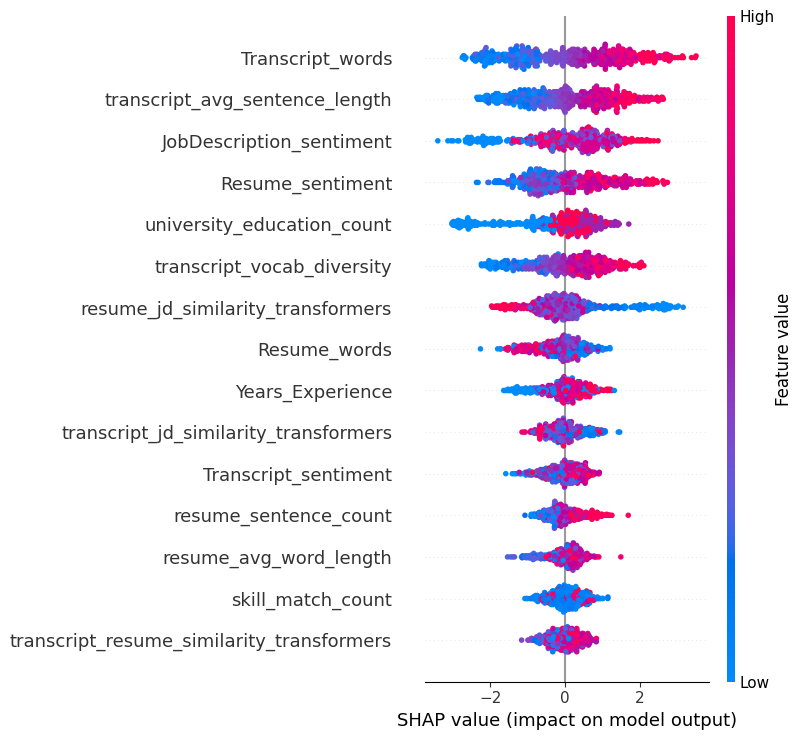

In [101]:
# Beeswarm plot
shap.summary_plot(shap_values, test_x)

# **Waterfall Plot**

In [107]:
# Finding the Lowest , middle , high probability predictions from the model

In [102]:
low_index = np.argmin(y_pred_xgb)  # Lowest prediction
medium_index = np.argsort(y_pred_xgb)[len(y_pred_xgb) // 2]  # Median prediction
high_index = np.argmax(y_pred_xgb)  # Highest prediction

### **Low prediction**

1. **For low predictions from this water fall plot we can observe that the number of words in transcript are contributing highly negitive  in the prediction of probability for success in interview**

2. **Even the transcript average sentence length
 , resume job description similarity is contributing highly negitive  in the prediction of probability for select in interview**

3. **Transcript job description similarity and  resume sentiment are the only 2 features which are contributing positively but they are also contributing very slightly for increase in the prediction**

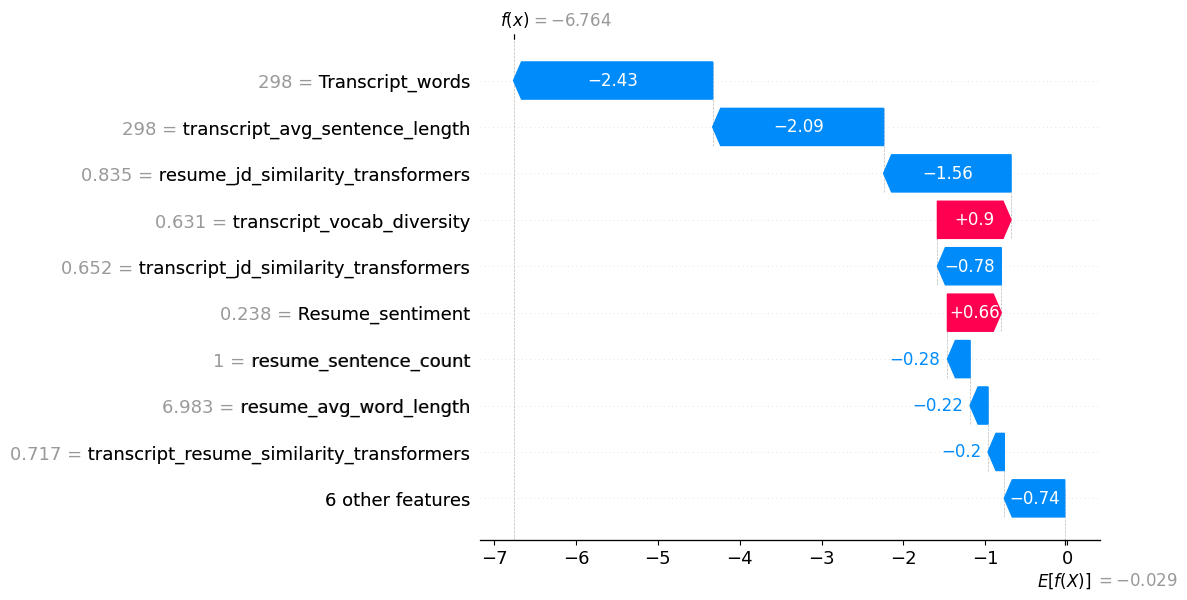

In [104]:
# Waterfall plots
shap.waterfall_plot(shap.Explanation(values=shap_values[low_index],
                                     base_values=explainer.expected_value,
                                     data=test_x.iloc[low_index]),
                    max_display=10)

### **Medium Prediction**

1. **For Medium predictions from this water fall plot we can observe that the number of words in transcript are contributing highly positive(+2.01)  in the prediction of probability for success in interview**

2. **Even the transcript average sentence length
 , resume sentiment is contributing highly positive in the prediction of probability for select in interview**

3. **Transcript vocabulary diversity , resume job descripition similarity using transformers are the ones whuch are contributing negitively  but they are also slightly negitive**

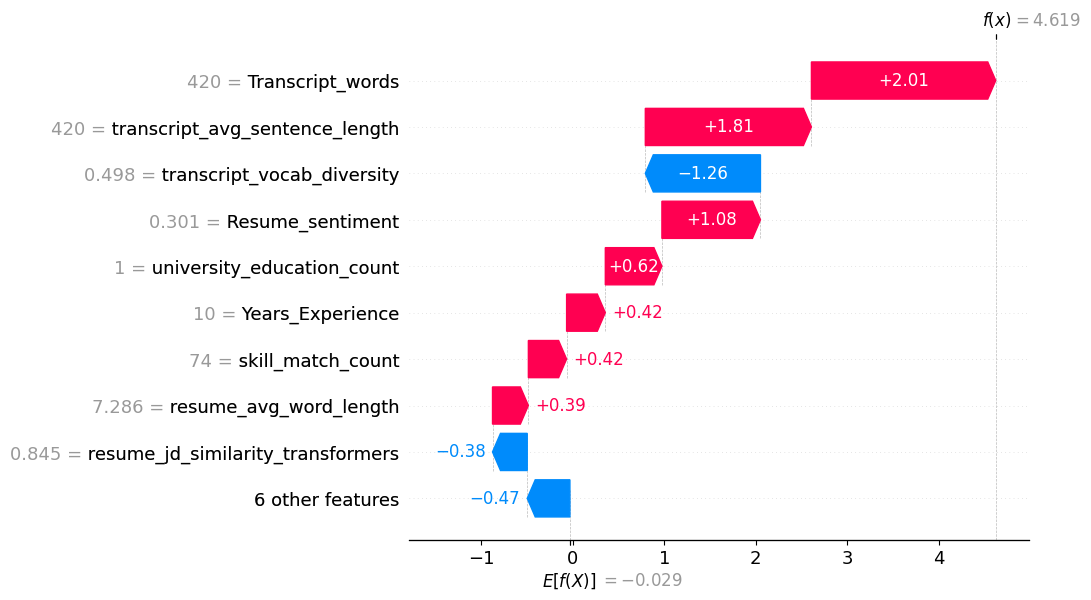

In [105]:

shap.waterfall_plot(shap.Explanation(values=shap_values[medium_index],
                                     base_values=explainer.expected_value,
                                     data=test_x.iloc[medium_index]),
                    max_display=10)

### **High prediction**

1. **For higher predictions from this water fall plot we can observe that the number of words in transcript are contributing highly positive(+2.7) even compared for medium predictions, in the prediction of probability for success in interview**

2. **Even the transcript average sentence length
 , transcript job description similarity , resume sentiment is contributing highly positive in the prediction of probability for select in interview**

3. **Transcript vocabulary diversity is the only feature whuch is contributing negitively  but that contribution is also very slightly (-0.45)**

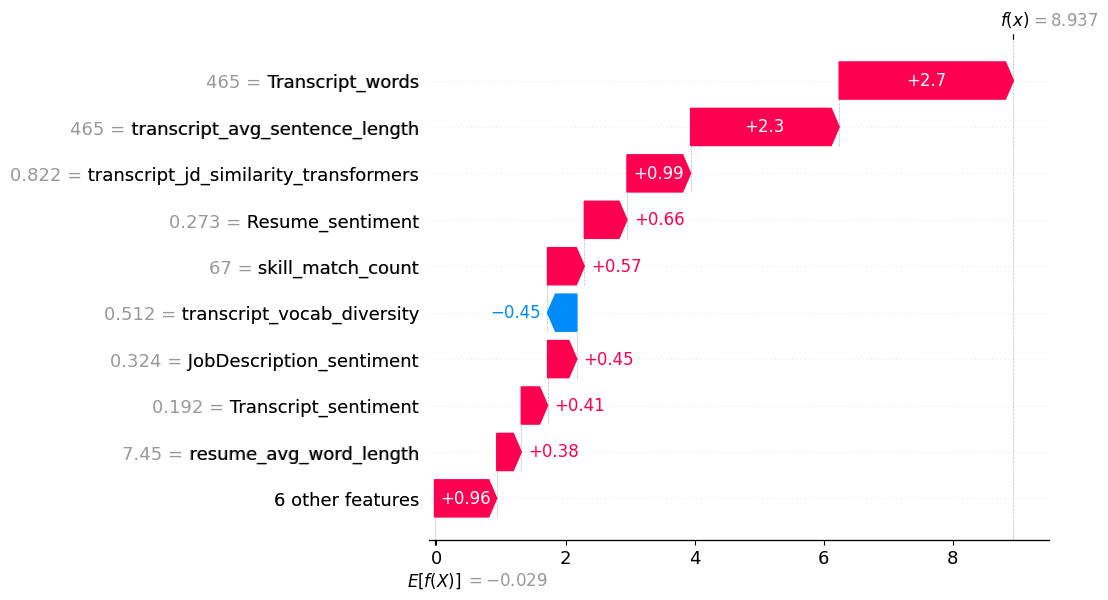

In [106]:
shap.waterfall_plot(shap.Explanation(values=shap_values[high_index],
                                     base_values=explainer.expected_value,
                                     data=test_x.iloc[high_index]),
                    max_display=10)

In [9]:
from sklearn.inspection import PartialDependenceDisplay

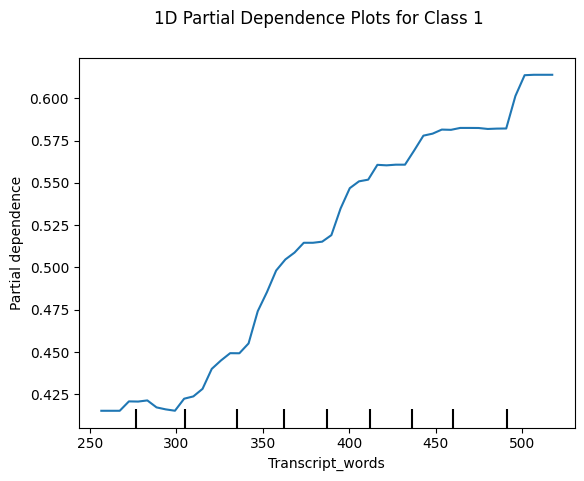

In [33]:

# Verify the feature alignment
expected_features = model.feature_names_in_  # Features used in training
train_x = train_x[expected_features]  # Align the features

# Specify features and target class
features_to_plot = ['Transcript_words']  # Indices of the features
target_class = 1  # Specify target class for multi-class PDP

# Generate Partial Dependence Plot
disp = PartialDependenceDisplay.from_estimator(
    xgb_model,
    train_x,
    features=features_to_plot,
    target=target_class,
    feature_names=expected_features,
    kind="average",
    grid_resolution=50
)

plt.suptitle(f"1D Partial Dependence Plots for Class {target_class}")
plt.show()


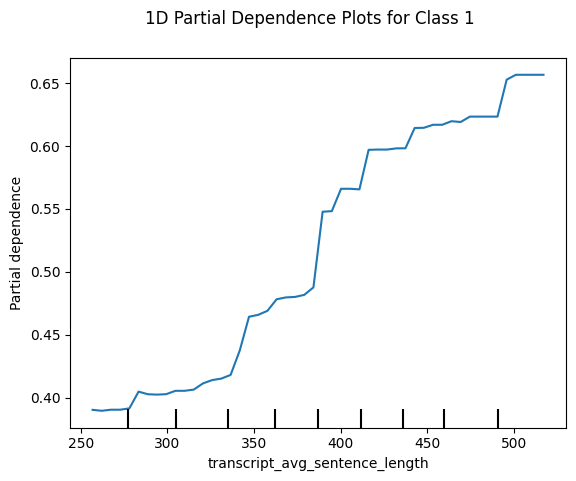

In [35]:

# Verify the feature alignment
expected_features = model.feature_names_in_  # Features used in training
train_x = train_x[expected_features]  # Align the features

# Specify features and target class
features_to_plot = ['transcript_avg_sentence_length']  # Indices of the features
target_class = 1  # Specify target class for multi-class PDP

# Generate Partial Dependence Plot
disp = PartialDependenceDisplay.from_estimator(
    xgb_model,
    train_x,
    features=features_to_plot,
    target=target_class,
    feature_names=expected_features,
    kind="average",
    grid_resolution=50
)

plt.suptitle(f"1D Partial Dependence Plots for Class {target_class}")
plt.show()


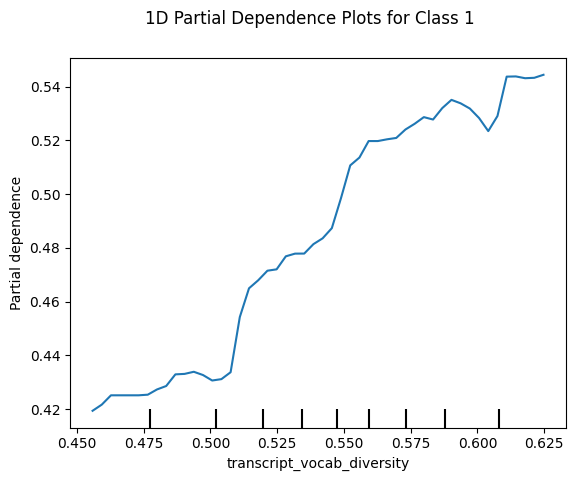

In [38]:

# Verify the feature alignment
expected_features = model.feature_names_in_  # Features used in training
train_x = train_x[expected_features]  # Align the features

# Specify features and target class
features_to_plot = ['transcript_vocab_diversity']  # Indices of the features
target_class = 1  # Specify target class for multi-class PDP

# Generate Partial Dependence Plot
disp = PartialDependenceDisplay.from_estimator(
    xgb_model,
    train_x,
    features=features_to_plot,
    target=target_class,
    feature_names=expected_features,
    kind="average",
    grid_resolution=50
)

plt.suptitle(f"1D Partial Dependence Plots for Class {target_class}")
plt.show()


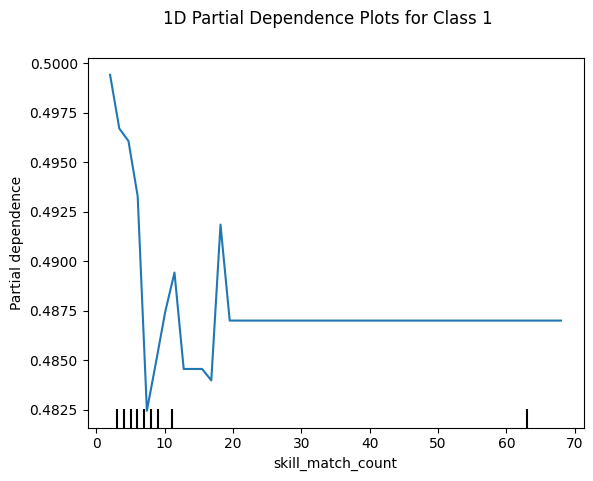

In [41]:

# Verify the feature alignment
expected_features = model.feature_names_in_  # Features used in training
train_x = train_x[expected_features]  # Align the features

# Specify features and target class
features_to_plot = ['skill_match_count']  # Indices of the features
target_class = 1  # Specify target class for multi-class PDP

# Generate Partial Dependence Plot
disp = PartialDependenceDisplay.from_estimator(
    xgb_model,
    train_x,
    features=features_to_plot,
    target=target_class,
    feature_names=expected_features,
    kind="average",
    grid_resolution=50
)

plt.suptitle(f"1D Partial Dependence Plots for Class {target_class}")
plt.show()


In [54]:
import pickle

with open("/content/xgb_classifier_model.pkl", "rb") as file:
    model = pickle.load(file)



In [60]:
# Assuming the model is trained for classification
model.classes_ = np.unique(train_y)


In [62]:
setattr(model, "use_label_encoder", False)  # Restore the missing attribute

In [65]:
# After loading the model
setattr(model, 'gpu_id', -1)  # Set to -1 if using CPU, or set appropriate value for GPU


In [70]:
from xgboost import XGBClassifier
import xgboost as xgb


In [72]:
# After loading the model
if hasattr(model, 'predictor') is False:
    model._Booster = xgb.Booster(model_file='/content/xgb_model.json')  # Manually set the Booster
    model.predictor = model._Booster  # Set the predictor attribute explicitly


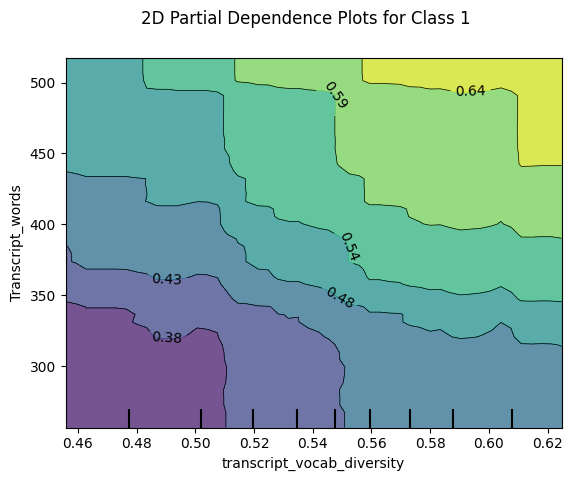

In [74]:

# Verify the feature alignment
expected_features = model.feature_names_in_  # Features used in training
train_x = train_x[expected_features]  # Align the features

# Specify features and target class
features_to_plot = [('transcript_vocab_diversity' , 'Transcript_words')]  # Indices of the features
target_class = 1  # Specify target class for multi-class PDP

# Generate Partial Dependence Plot
disp = PartialDependenceDisplay.from_estimator(
    xgb_model,
    train_x,
    features=features_to_plot,
    target=target_class,
    feature_names=expected_features,
    kind="average",
    grid_resolution=50
)

plt.suptitle(f"2D Partial Dependence Plots for Class {target_class}")
plt.show()


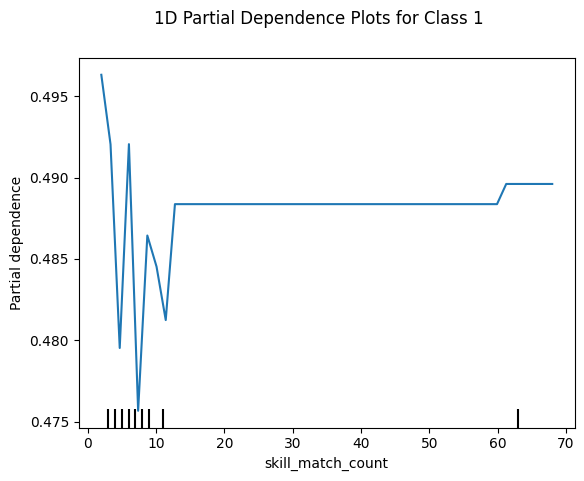

In [75]:

# Verify the feature alignment
expected_features = model.feature_names_in_  # Features used in training
train_x = train_x[expected_features]  # Align the features

# Specify features and target class
features_to_plot = ['skill_match_count']  # Indices of the features
target_class = 1  # Specify target class for multi-class PDP

# Generate Partial Dependence Plot
disp = PartialDependenceDisplay.from_estimator(
    model,
    train_x,
    features=features_to_plot,
    target=target_class,
    feature_names=expected_features,
    kind="average",
    grid_resolution=50
)

plt.suptitle(f"1D Partial Dependence Plots for Class {target_class}")
plt.show()
